In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import multiclass
from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from keras.utils import np_utils
from keras.models import Sequential, Model, load_model
from keras.preprocessing import sequence
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import  Concatenate,Dense, Dropout, Embedding, Conv1D, MaxPool1D, GlobalMaxPool1D, Activation, SpatialDropout1D, LSTM, SimpleRNN, GRU
from keras.optimizers import Adam, SGD, RMSprop
from keras import losses, optimizers
from keras import preprocessing
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy

from matplotlib import pyplot as plt

import tensorflow as tf
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

In [2]:
df = pd.read_json('data/News_Category_Dataset_v2.json', lines=True)

In [3]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
df.category = df.category.map(lambda x: "WORLD NEWS" if x == "WORLDPOST" else x)
df.category = df.category.map(lambda x: "STYLE AND BEAUTY" if x == "STYLE" else x)
df.category = df.category.map(lambda x: "STYLE AND BEAUTY" if x == "STYLE & BEAUTY" else x)
df.category = df.category.map(lambda x: "PARENT" if x == "PARENTING" else x)
df.category = df.category.map(lambda x: "ARTS & CULTURE" if x == "ARTS" else x)
df.category = df.category.map(lambda x: "ARTS & CULTURE" if x == "CULTURE & ARTS" else x)
df.sort_values('headline', inplace=True, ascending=False)
duplicates = df.duplicated('headline', keep = False)
df = df[~duplicates]

In [4]:
tokenizer = Tokenizer()
df['text'] = df.headline + " " + df.short_description + " " + df.authors
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))

In [5]:
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

In [9]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
f = open('data/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Ukupan broj razlicitih tokena: ', len(word_index))
print('Ukupno vektora: ', len(embeddings_index))

Ukupan broj razlicitih tokena:  133394
Ukupno vektora:  400000


In [10]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)
X = np.array(X)
y = np_utils.to_categorical(list(df.c2id))

In [11]:
X_train_and_validation, X_test, y_train_and_validation, y_test = model_selection.\
    train_test_split(X, y, test_size = 0.33, stratify = y, random_state = 4)
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X_train_and_validation,\
    y_train_and_validation, train_size = 0.8, random_state = 4, stratify = y_train_and_validation)

In [12]:
inp = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(int_category), activation='softmax')(drop)

model1 = Model(inputs=inp, outputs=outp)
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      13339500    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 64)       12864       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 64)       19264       embedding[0][0]                  
_______________________________________________________________________________________

In [13]:
history1 = model1.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_validation, y_validation))

Epoch 1/20
832/832 [==============================] - 49s 59ms/step - loss: 2.1924 - accuracy: 0.4158 - val_loss: 1.5314 - val_accuracy: 0.5772
Epoch 2/20
832/832 [==============================] - 48s 58ms/step - loss: 1.6543 - accuracy: 0.5425 - val_loss: 1.3549 - val_accuracy: 0.6202
Epoch 3/20
832/832 [==============================] - 49s 59ms/step - loss: 1.5351 - accuracy: 0.5752 - val_loss: 1.2821 - val_accuracy: 0.6435
Epoch 4/20
832/832 [==============================] - 50s 60ms/step - loss: 1.4707 - accuracy: 0.5880 - val_loss: 1.2354 - val_accuracy: 0.6601
Epoch 5/20
832/832 [==============================] - 52s 63ms/step - loss: 1.4296 - accuracy: 0.6009 - val_loss: 1.2096 - val_accuracy: 0.6660
Epoch 6/20
832/832 [==============================] - 56s 68ms/step - loss: 1.4039 - accuracy: 0.6069 - val_loss: 1.1902 - val_accuracy: 0.6720
Epoch 7/20
832/832 [==============================] - 53s 64ms/step - loss: 1.3818 - accuracy: 0.6131 - val_loss: 1.1670 - val_accuracy:

In [14]:
def EvaluateModel(model, X_test, y_test, history):
    score = model.evaluate(X_test, y_test)
    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])
    
    epochs = history.epoch
    
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(12,8))
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs, loss, c='red', label = 'training')
    plt.plot(epochs, validation_loss, c='orange', label='validation')
    plt.legend(loc = 'best')
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(epochs, accuracy, c='red', label = 'training')
    plt.plot(epochs, validation_accuracy, c = 'orange', label = 'validation')
    plt.legend(loc = 'best')
    plt.show()

2049/2049 [==============================] - 7s 4ms/step - loss: 1.0944 - accuracy: 0.6981
Test loss:  1.0943739414215088
Test accuracy:  0.6980792284011841


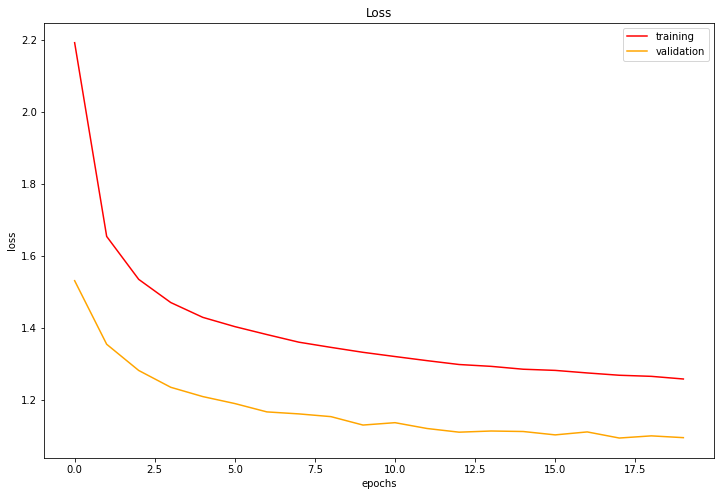

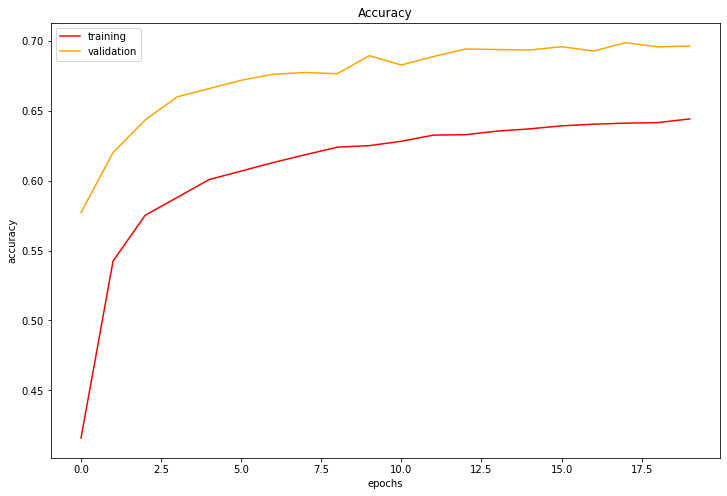

In [15]:
EvaluateModel(model1, X_test, y_test, history1)

In [17]:
inp = Input(shape=(maxlen,), dtype='int32')
x = embedding_layer(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size=3)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
outp = Dense(len(int_category), activation="softmax")(x)

model2 = Model(inp, outp)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      13339500    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 100)      0           embedding[2][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 256)      176640      spatial_dropout1d_1[0][0]        
_______________________________________________________________________________________

In [18]:
history2 = model2.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_validation, y_validation))

Epoch 1/10
832/832 [==============================] - 383s 460ms/step - loss: 1.7360 - accuracy: 0.5216 - val_loss: 1.2468 - val_accuracy: 0.6431
Epoch 2/10
832/832 [==============================] - 366s 440ms/step - loss: 1.2285 - accuracy: 0.6496 - val_loss: 1.0756 - val_accuracy: 0.6899
Epoch 3/10
832/832 [==============================] - 390s 469ms/step - loss: 1.0764 - accuracy: 0.6876 - val_loss: 0.9893 - val_accuracy: 0.7134
Epoch 4/10
832/832 [==============================] - 393s 472ms/step - loss: 0.9904 - accuracy: 0.7123 - val_loss: 0.9421 - val_accuracy: 0.7278
Epoch 5/10
832/832 [==============================] - 375s 451ms/step - loss: 0.9317 - accuracy: 0.7261 - val_loss: 0.9116 - val_accuracy: 0.7364
Epoch 6/10
832/832 [==============================] - 429s 516ms/step - loss: 0.8877 - accuracy: 0.7384 - val_loss: 0.8809 - val_accuracy: 0.7451
Epoch 7/10
832/832 [==============================] - 401s 482ms/step - loss: 0.8512 - accuracy: 0.7473 - val_loss: 0.8793 -

2049/2049 [==============================] - 54s 27ms/step - loss: 0.8661 - accuracy: 0.7544
Test loss:  0.8661239147186279
Test accuracy:  0.7544205188751221


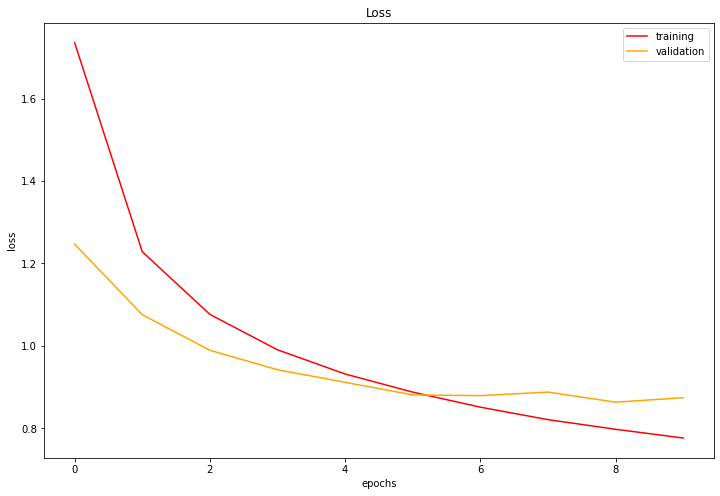

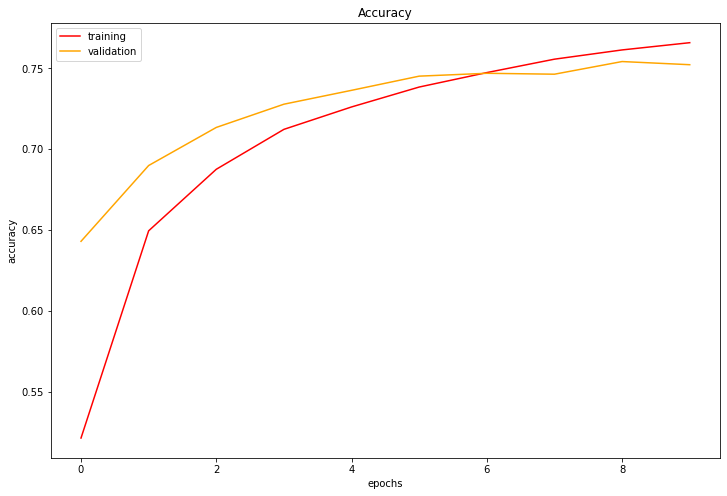

In [19]:
EvaluateModel(model2, X_test, y_test, history2)

In [29]:
p1 = model1.predict(X_test, verbose=0)
print(metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(p1, axis=1)))
print(metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(p1, axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      1264
           1       0.68      0.34      0.46      1488
           2       0.55      0.49      0.52      1950
           3       0.60      0.26      0.37       377
           4       0.66      0.51      0.58      1683
           5       0.60      0.52      0.56      1120
           6       0.87      0.66      0.75      1126
           7       0.55      0.42      0.48       331
           8       0.66      0.80      0.72      5287
           9       0.72      0.32      0.44       411
          10       0.63      0.22      0.32       462
          11       0.77      0.85      0.81      2050
          12       0.79      0.34      0.48       461
          13       0.54      0.31      0.39       862
          14       0.54      0.67      0.60      2199
          15       0.86      0.77      0.81      1342
          16       0.54      0.24      0.33      1135
          17       0.91    

In [30]:
p2 = model2.predict(X_test, verbose=0)
print(metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(p2, axis=1)))
print(metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(p2, axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1264
           1       0.61      0.55      0.58      1488
           2       0.65      0.58      0.61      1950
           3       0.48      0.58      0.52       377
           4       0.71      0.59      0.64      1683
           5       0.58      0.66      0.62      1120
           6       0.83      0.74      0.78      1126
           7       0.47      0.63      0.53       331
           8       0.80      0.78      0.79      5287
           9       0.67      0.52      0.59       411
          10       0.56      0.55      0.56       462
          11       0.88      0.87      0.87      2050
          12       0.74      0.46      0.57       461
          13       0.58      0.48      0.53       862
          14       0.70      0.69      0.69      2199
          15       0.89      0.80      0.85      1342
          16       0.63      0.36      0.46      1135
          17       0.71    

Ovi modeli nisu u potpunosti samostalno implementirani, delovi koda su korisceni iz literature. Pokusali smo da nadjemo model koji ce biti relativno dobar i sa dobrim rezultatima.